## Прогнозирование уровня средней заработной платы в России
Для выполнения этого задания вам понадобятся данные о среднемесячных уровнях заработной платы в России:

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, [здесь](http://sophist.hse.ru/exes/tables/WAG_M.htm).

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Придерживайтесь стандартного алгоритма построения прогноза:

1. Визуальный анализ ряда
2. Стабилизация дисперсии (при необходимости)
3. Выбор порядка дифференцирования
4. Выбор начальных приближений для $p,q,P,Q$
5. Обучение и сравнение моделей-кандидатов, выбор победителя
6. Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения $p,q,P,Q$.
7. Прогнозирование с помощью финальной модели.

Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.

In [55]:
from scipy import stats
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%pylab inline

data = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.rename(columns={'WAG_C_M': 'salary'}, inplace=True)
data.head()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


,salary
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


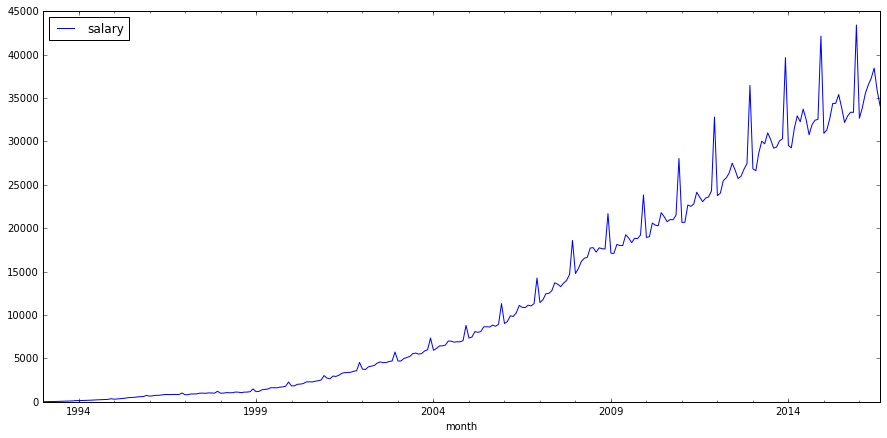

In [56]:
plt.figure(figsize(15,7))
data.plot()
pylab.show()

In [57]:
def invboxcox(y,lmbda):
    return np.exp(y) if lmbda == 0 else np.exp(np.log(lmbda*y + 1)/lmbda)

Критерий Дики-Фуллера: p=0.991850


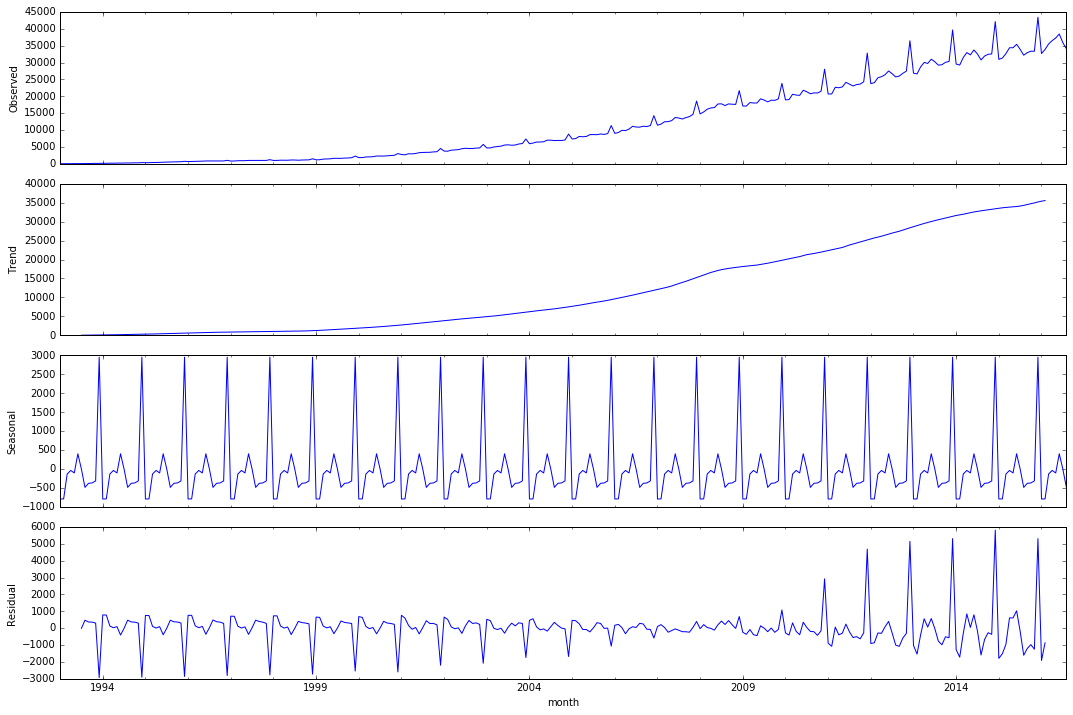

In [58]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


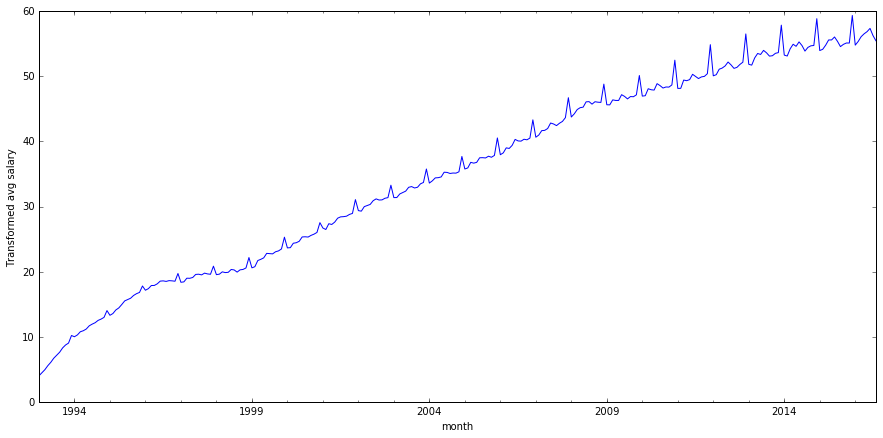

In [59]:
data['salary_box'], lmbda = stats.boxcox(data.salary)
plt.figure(figsize(15,7))
data.salary_box.plot()
plt.ylabel(u'Transformed avg salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box)[1])

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности и визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


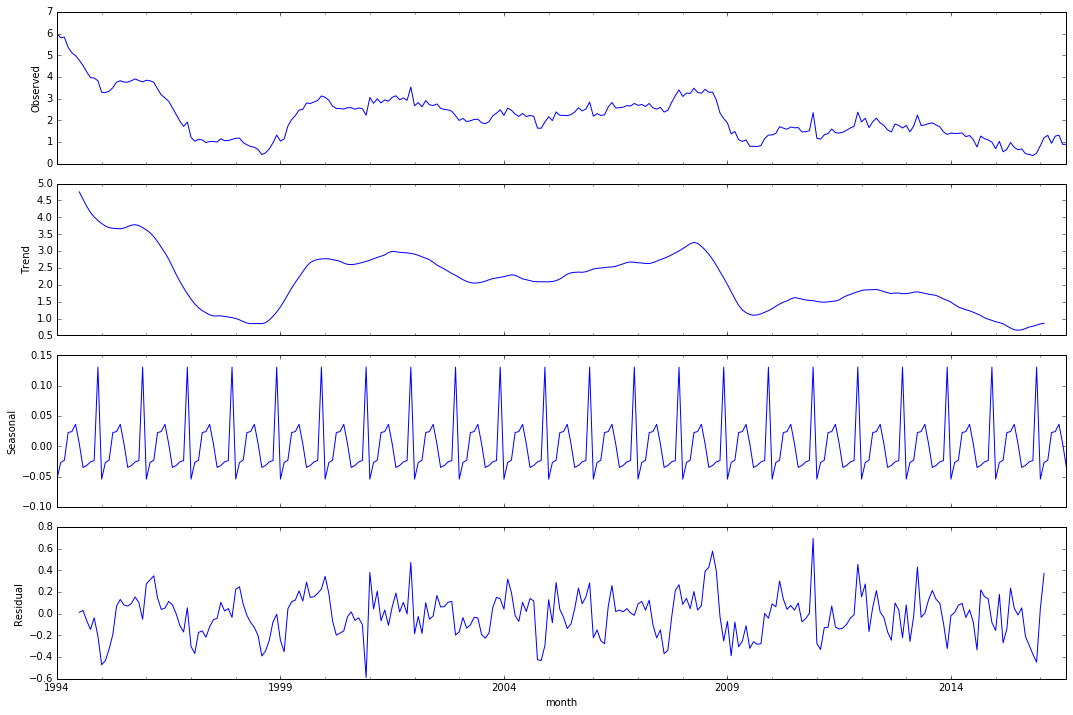

In [60]:
data['salary_box_diff'] = data.salary_box - data.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


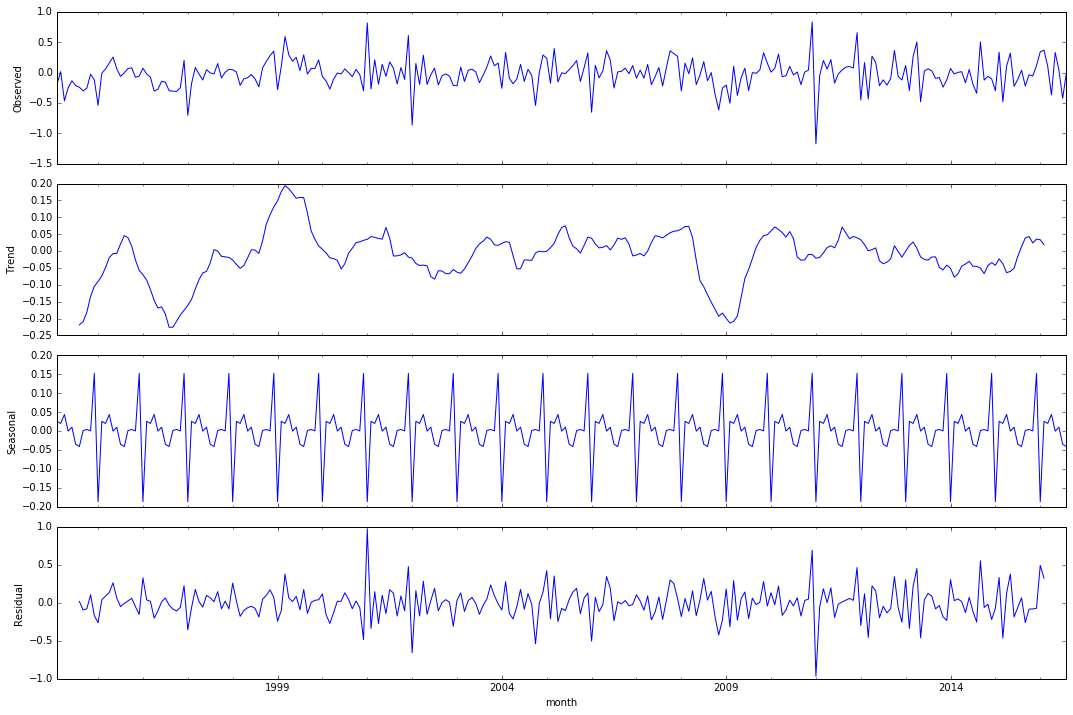

In [61]:
data['salary_box_diff2'] = data.salary_box_diff - data.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и мы избавились от тренда.

### Подбор модели

Посмотрим на ACF и PACF полученного ряда:

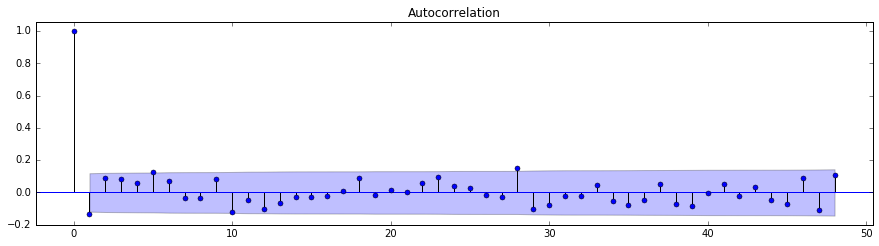

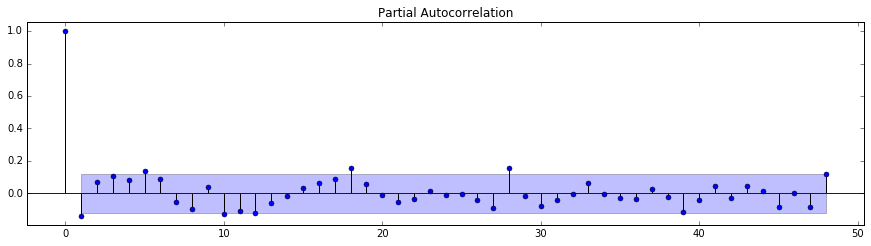

In [62]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=5, P=1, p=5

In [63]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [64]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

72

In [65]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 3, 0, 0)
wrong parameters: (2, 3, 1, 0)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 3, 0, 0)
wrong parameters: (3, 3, 1, 0)
wrong parameters: (3, 4, 0, 0)
wrong parameters: (3, 4, 1, 0)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 3, 0, 0)
wrong parameters: (4, 3, 1, 0)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (4, 4, 1, 0)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 2, 1, 0)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 3, 1, 0)
wrong parameters: (5, 4, 0, 0)
wrong parameters: (5, 4, 1, 0)
Wall time: 42.6 s


In [66]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
44  (5, 5, 1, 0) -25.970736
43  (5, 5, 0, 0) -22.665401
20  (1, 5, 1, 0) -15.867143
31  (3, 5, 0, 0) -15.228473
32  (3, 5, 1, 0) -14.783234


Лучшая модель:

In [67]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.985
Date:                            Thu, 05 Jan 2017   AIC                            -25.971
Time:                                    00:13:29   BIC                             17.817
Sample:                                01-01-1993   HQIC                            -8.415
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0267      9.943      0.003      0.998     -19.461      19.514
ar.L2          0.0089      6.723   

Её остатки:

Критерий Стьюдента: p=0.174544
Критерий Дики-Фуллера: p=0.000000


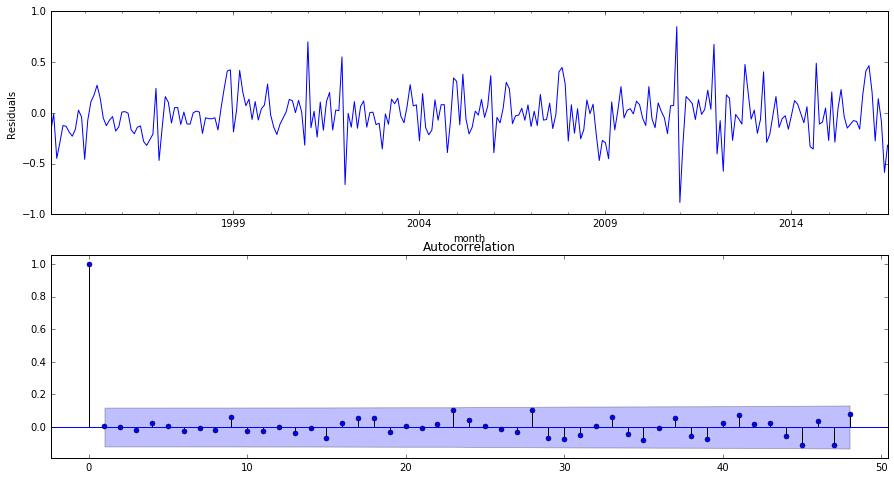

In [68]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

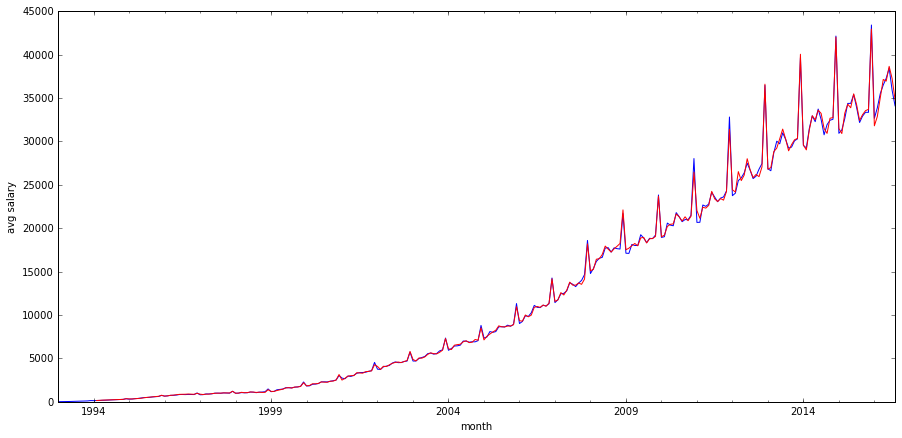

In [69]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.salary.plot()
data.model[13:].plot(color='r')
plt.ylabel('avg salary')
pylab.show()

### Прогноз

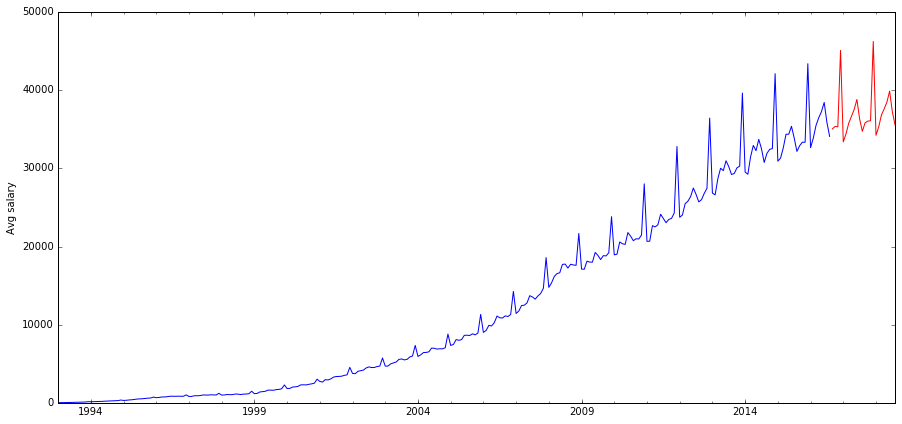

In [70]:
data2 = data[['salary']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns=data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=data.shape[0], end=data.shape[0] + 24), lmbda)

plt.figure(figsize(15,7))
data2.salary.plot()
data2.forecast.plot(color='r')
plt.ylabel('Avg salary')
pylab.show()